In [2]:
import numpy as np
import pandas as pd

def generate_credit_transition_matrix_with_withdraw_prob(withdraw_prob, main_diagonal_probs):
    n_ratings = 10
    n_columns = 12  # Including withdraw and default columns
    matrix = np.zeros((n_ratings, n_columns))
    
    stddev = withdraw_prob / 10
    
    # Specified default rates
    default_rates = np.array([0.00005, 0.0001, 0.0004, 0.0009, 0.0025, 
                              0.007, 0.0128, 0.0601, 0.1575, 0.3537])

    for i in range(n_ratings):
        # Assign specified default probability
        default_prob = default_rates[i]
        
        # Assign withdraw probability following a normal distribution centered around withdraw_prob
        withdraw_prob_sample = np.random.normal(withdraw_prob, stddev)
        
        # Ensure withdraw probability is within the valid range [0, 1]
        withdraw_prob_sample = max(0, min(withdraw_prob_sample, 1))
        
        # Calculate the remaining probability for other transitions
        remaining_prob = 1 - default_prob - withdraw_prob_sample
        
        # Set main diagonal probability
        main_diagonal = np.random.normal(main_diagonal_probs[i], main_diagonal_probs[i]/100)
        
        # Calculate side probabilities based on the number of adjacent ratings
        num_adjacent_ratings = min(i, n_ratings - 1 - i)
        if i == 0:  # Top rating
            side_prob = (remaining_prob - main_diagonal) / 2  # Only two adjacent ratings (downwards)
        elif i == 9:  # Bottom rating
            side_prob = (remaining_prob - main_diagonal) / 2  # Only two adjacent ratings (upwards)
        elif num_adjacent_ratings == 1:
            side_prob = (remaining_prob - main_diagonal) / 3
        elif num_adjacent_ratings == 2:
            side_prob = (remaining_prob - main_diagonal) / 4
        elif num_adjacent_ratings == 3:
            side_prob = (remaining_prob - main_diagonal) / 5
        else:
            side_prob = (remaining_prob - main_diagonal) / 6
        
        # Set main diagonal
        matrix[i, i] = main_diagonal
        
        # Set probabilities for adjacent ratings with randomness
        for j in range(1, 4):
            if i - j >= 0:  # Lower adjacent ratings, i.e. higher ratings
                matrix[i, i - j] = max(0, side_prob * (4 - j) * np.random.uniform(0.7, 0.9))
            if i + j < n_ratings:  # Upper adjacent ratings, i.e. lower ratings
                matrix[i, i + j] = max(0, side_prob * (4 - j) * np.random.uniform(1.1, 1.3))
        
        # Normalize probabilities for other states while keeping main diagonal fixed
        before_i = np.sum(matrix[i, :i])
        after_i = np.sum(matrix[i, i+1:n_ratings])
        total_adjacent_prob = before_i + after_i
        if total_adjacent_prob > 0:
            matrix[i, :i] *= (remaining_prob - main_diagonal) / total_adjacent_prob
            matrix[i, i+1:n_ratings] *= (remaining_prob - main_diagonal) / total_adjacent_prob
        
        matrix[i, -2] = withdraw_prob_sample  # Withdraw probability
        matrix[i, -1] = default_prob  # Default probability

    # Ensure transition probabilities for Rating 1 and Rating 10 are correctly adjusted
    matrix[0, 1] = max(matrix[0, 1], 1e-5)  # Ensure non-zero probability to transition to Rating 2
    matrix[0, 2] = max(matrix[0, 2], 1e-5)  # Ensure non-zero probability to transition to Rating 3
    matrix[9, 8] = max(matrix[9, 8], 1e-5)  # Ensure non-zero probability to transition to Rating 9
    matrix[9, 7] = max(matrix[9, 7], 1e-5)  # Ensure non-zero probability to transition to Rating 8
    
    # Define row and column labels
    row_labels = [f'Rating {i+1}' for i in range(10)]
    column_labels = [f'Rating {i+1}' for i in range(10)] + ['Withdraw', 'Default']

    # Create a DataFrame with labels
    transition_matrix_df = pd.DataFrame(matrix, index=row_labels, columns=column_labels)

    return transition_matrix_df

# Example usage
withdraw_prob = 0.03  # Centered around value% withdraw probability
# Main diagonal probabilities for each rating
main_diagonal_probs = [0.94, 0.92, 0.90, 0.87, 0.85, 0.82, 0.80, 0.77, 0.73, 0.58]
transition_matrix_df = generate_credit_transition_matrix_with_withdraw_prob(withdraw_prob, main_diagonal_probs)
transition_matrix_df

,Rating 1,Rating 2,Rating 3,Rating 4,Rating 5,Rating 6,Rating 7,Rating 8,Rating 9,Rating 10,Withdraw,Default
Rating 1,0.947128,0.012867,0.009480,0.004424,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.026052,0.00005
Rating 2,0.011915,0.915036,0.019479,0.014287,0.006722,0.000000,0.000000,0.000000,0.000000,0.000000,0.032462,0.00010
Rating 3,0.009931,0.012673,0.905737,0.022438,0.015162,0.006702,0.000000,0.000000,0.000000,0.000000,0.026957,0.00040
Rating 4,0.008024,0.015027,0.020093,0.855187,0.033793,0.020552,0.011324,0.000000,0.000000,0.000000,0.035099,0.00090
Rating 5,0.000000,0.008143,0.015189,0.024359,0.851199,0.034525,0.025466,0.012277,0.000000,0.000000,0.026342,0.00250
Rating 6,0.000000,0.000000,0.008436,0.017774,0.027242,0.828833,0.038233,0.024890,0.012868,0.000000,0.034725,0.00700
Rating 7,0.000000,0.000000,0.000000,0.009890,0.018210,0.029389,0.803355,0.046498,0.033130,0.014871,0.031857,0.01280
Rating 8,0.000000,0.000000,0.000000,0.000000,0.009895,0.018294,0.031906,0.770997,0.042983,0.028035,0.037789,0.06010
Rating 9,0.000000,0.000000,0.000000,0.000000,0.000000,0.008999,0.015517,0.025256,0.724519,0.037935,0.030274,0.15750
Rating 10,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004766,0.008512,0.012646,0.590362,0.030014,0.35370


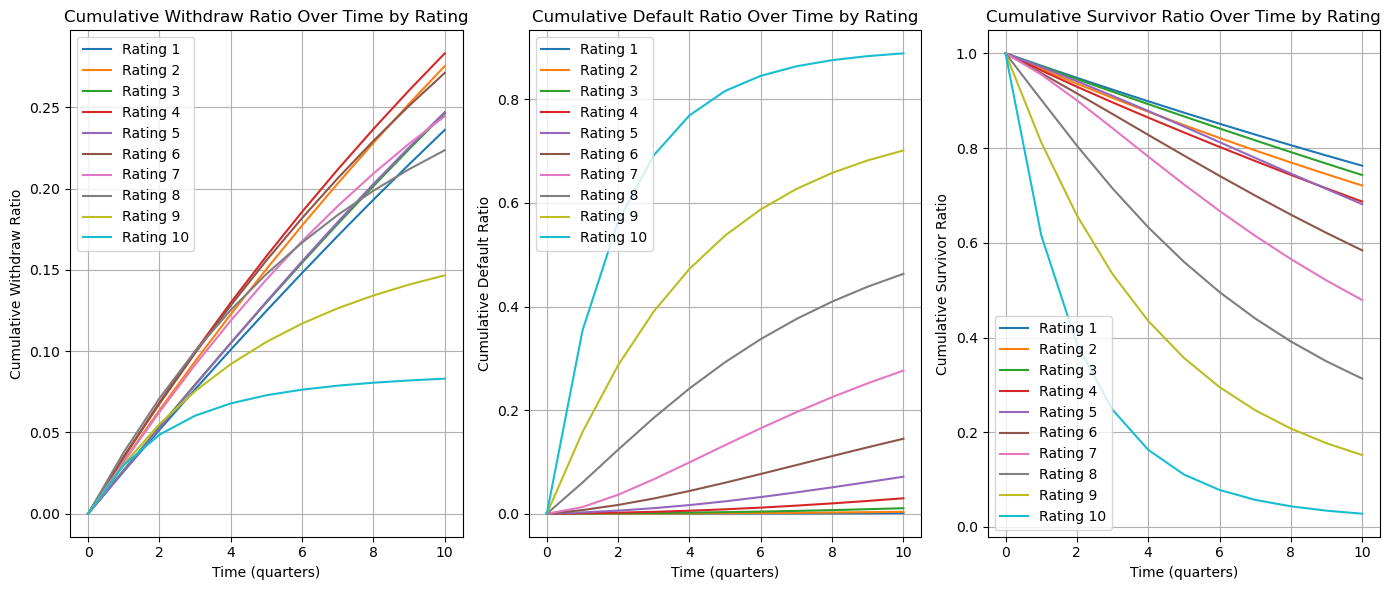

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def simulate_transitions_matrix(transition_matrix, quarters=11, lgd=1.0, ead=1.0):
    n_ratings = transition_matrix.shape[0]  # Number of ratings (excluding Withdraw and Default)
    n_columns = transition_matrix.shape[1]  # Number of states including Withdraw and Default

    # Initialize matrices to store cumulative results
    cumulative_withdraws = np.zeros((quarters, n_ratings))
    cumulative_defaults = np.zeros((quarters, n_ratings))
    cumulative_survivors = np.zeros((quarters, n_ratings))
    ecl_per_quarter = np.zeros((quarters, n_ratings))  # To store ECL for each quarter and rating
    distributions_over_time = []  # To store the distribution matrices for each time step

    for i in range(n_ratings):
        cumulative_survivors[0, i] = 1

    # Initial distribution of obligors (start with identity matrix for initial distribution)
    current_distribution = np.eye(n_ratings)
    initial_distribution_with_exit_states = np.hstack((current_distribution, np.zeros((n_ratings, 2))))
    distributions_over_time.append(initial_distribution_with_exit_states.copy())  # Store initial distribution

    for t in range(1, quarters):
        next_distribution = np.zeros_like(current_distribution)

        # Update next_distribution using matrix multiplication
        transitions = np.dot(current_distribution, transition_matrix.values[:, :n_ratings])

        # Update next_distribution matrix
        next_distribution[:, :n_ratings] += transitions
        
        # Accumulate withdraws and defaults for each rating
        cumulative_withdraws[t, :] = cumulative_withdraws[t - 1, :] + np.dot(current_distribution, transition_matrix.values[:, -2])
        cumulative_defaults[t, :] = cumulative_defaults[t - 1, :] + np.dot(current_distribution, transition_matrix.values[:, -1])
        
        # Update survivors and ECL
        cumulative_survivors[t, :] = np.sum(next_distribution[:, :n_ratings], axis=1)
        default_count = cumulative_defaults[t, :]
        ecl_per_quarter[t, :] = default_count * lgd * ead * 10000

        # Create the distribution matrix with cumulative withdraws and defaults
        current_distribution_with_exit_states = np.hstack((next_distribution, cumulative_withdraws[t, :].reshape(-1, 1), cumulative_defaults[t, :].reshape(-1, 1)))
        distributions_over_time.append(current_distribution_with_exit_states.copy())  # Store distribution for this quarter

        current_distribution = next_distribution

    cumulative_ecl = np.sum(ecl_per_quarter, axis=0)

    return cumulative_withdraws, cumulative_defaults, cumulative_survivors, ecl_per_quarter, cumulative_ecl, distributions_over_time

# Simulate the transitions over 11 unit times
quarters = 11
cumulative_withdraws, cumulative_defaults, cumulative_survivors, ecl_per_quarter, cumulative_ecl, distributions_over_time = simulate_transitions_matrix(transition_matrix_df, quarters)

# Plot the results
plt.figure(figsize=(14, 6))

# Plot Withdraw rates over time
plt.subplot(1, 3, 1)
for i in range(10):
    plt.plot(range(quarters), cumulative_withdraws[:, i], label=f'Rating {i+1}')
plt.xlabel('Time (quarters)')
plt.ylabel('Cumulative Withdraw Ratio')
plt.title('Cumulative Withdraw Ratio Over Time by Rating')
plt.legend()
plt.grid(True)

# Plot Default rates over time
plt.subplot(1, 3, 2)
for i in range(10):
    plt.plot(range(quarters), cumulative_defaults[:, i], label=f'Rating {i+1}')
plt.xlabel('Time (quarters)')
plt.ylabel('Cumulative Default Ratio')
plt.title('Cumulative Default Ratio Over Time by Rating')
plt.legend()
plt.grid(True)

# Plot Survivors rates over time
plt.subplot(1, 3, 3)
for i in range(10):
    plt.plot(range(quarters), cumulative_survivors[:, i], label=f'Rating {i+1}')
plt.xlabel('Time (quarters)')
plt.ylabel('Cumulative Survivor Ratio')
plt.title('Cumulative Survivor Ratio Over Time by Rating')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [67]:
for i in range(10):
    sum = cumulative_withdraws[:, i] + cumulative_defaults[:, i] + cumulative_survivors[:, i]
    print(sum)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


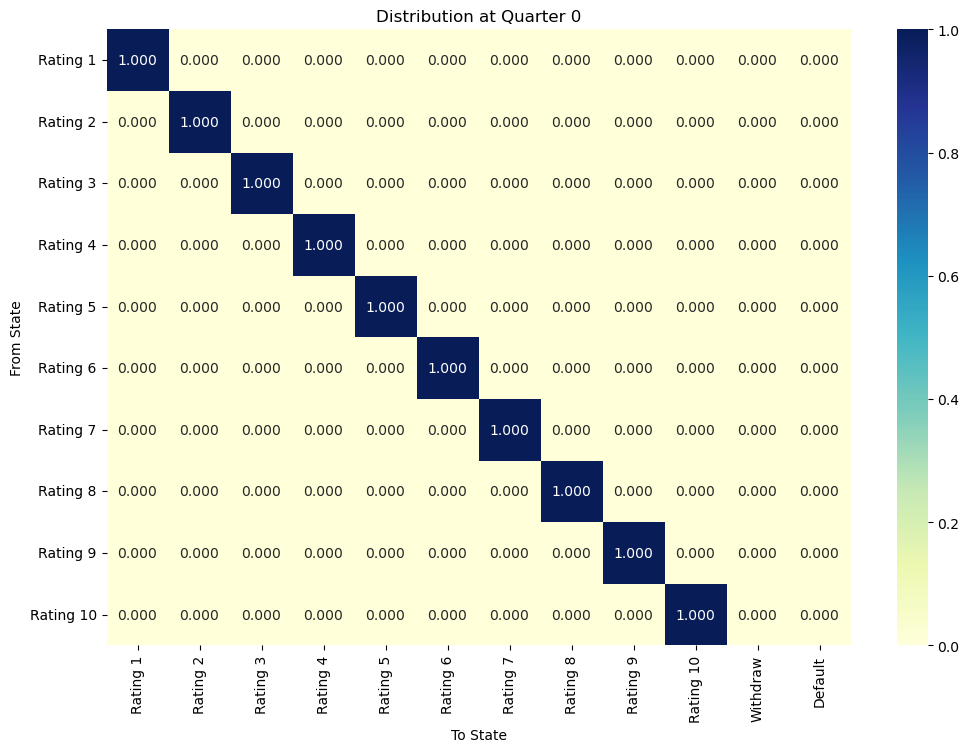

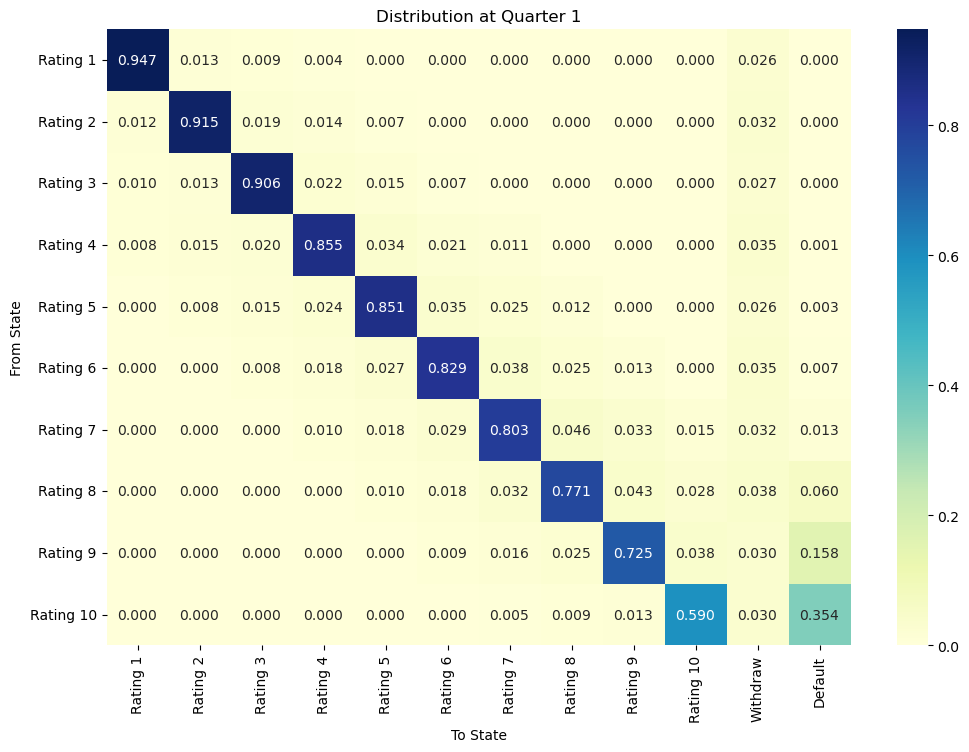

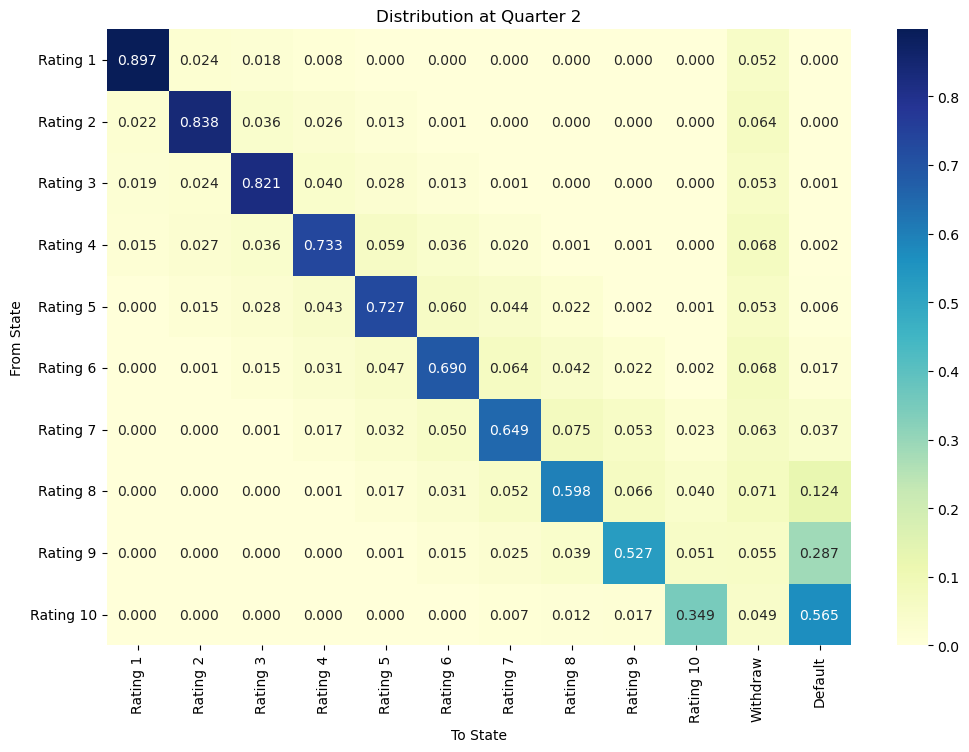

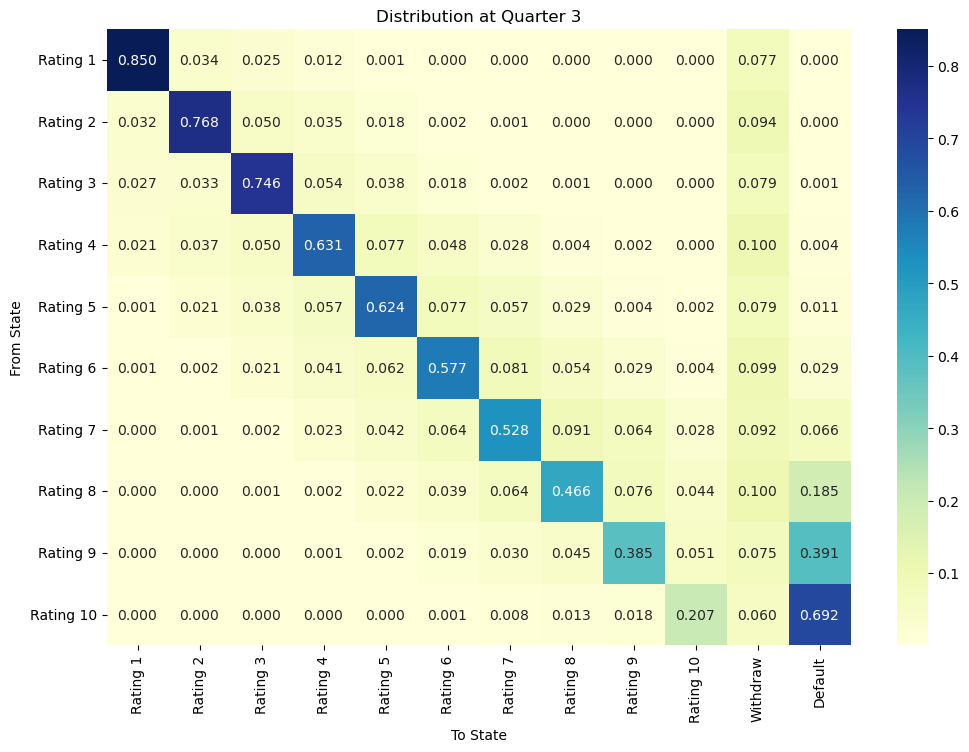

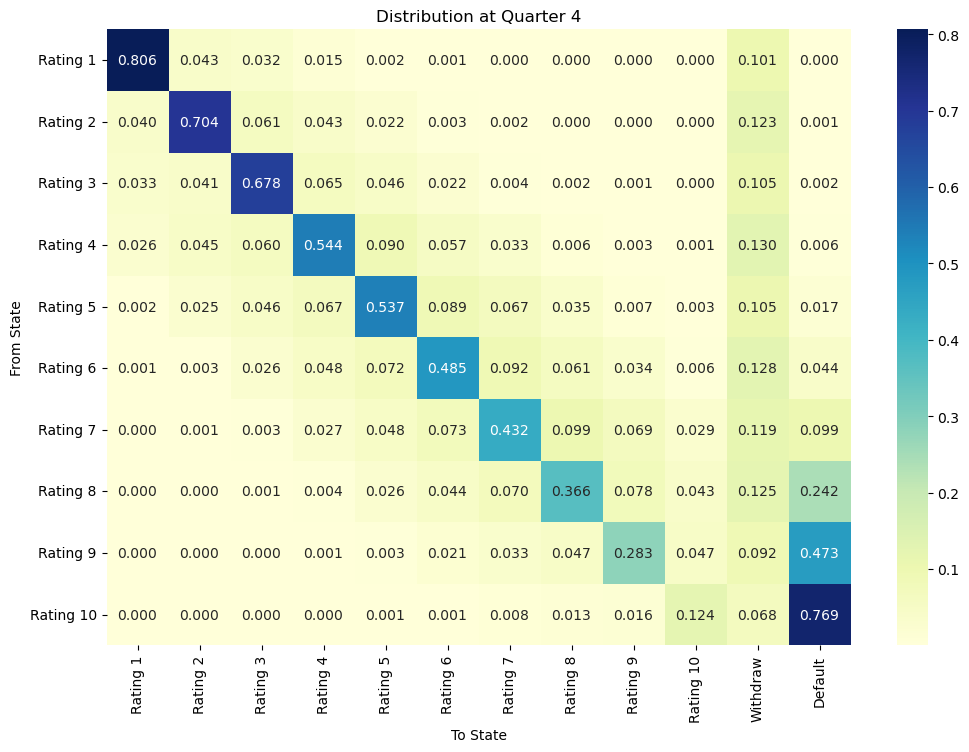

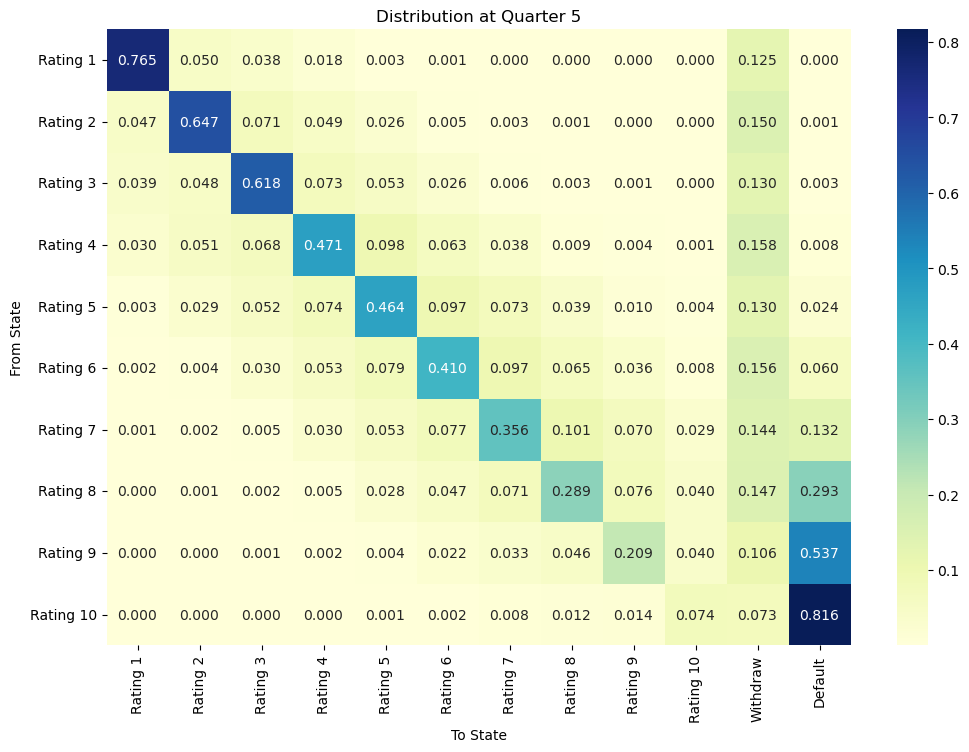

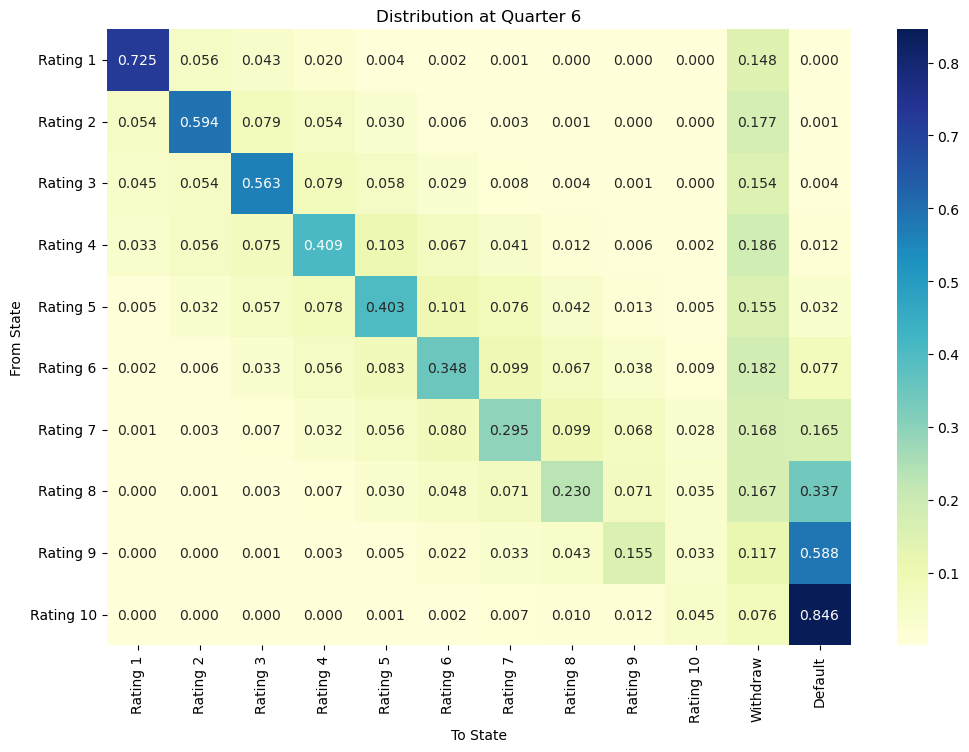

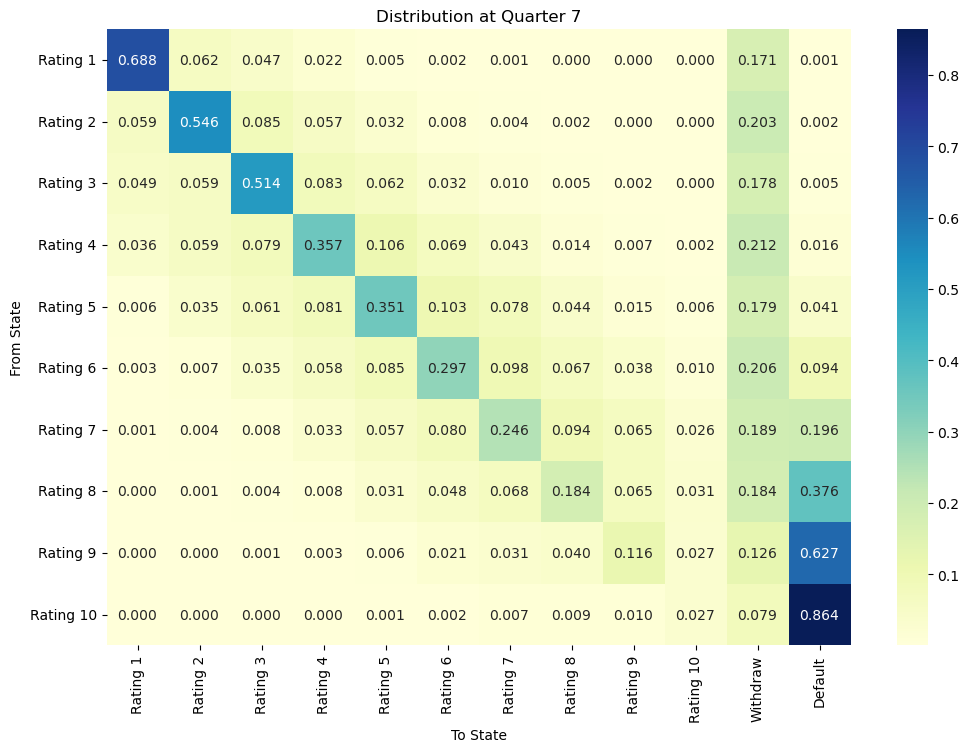

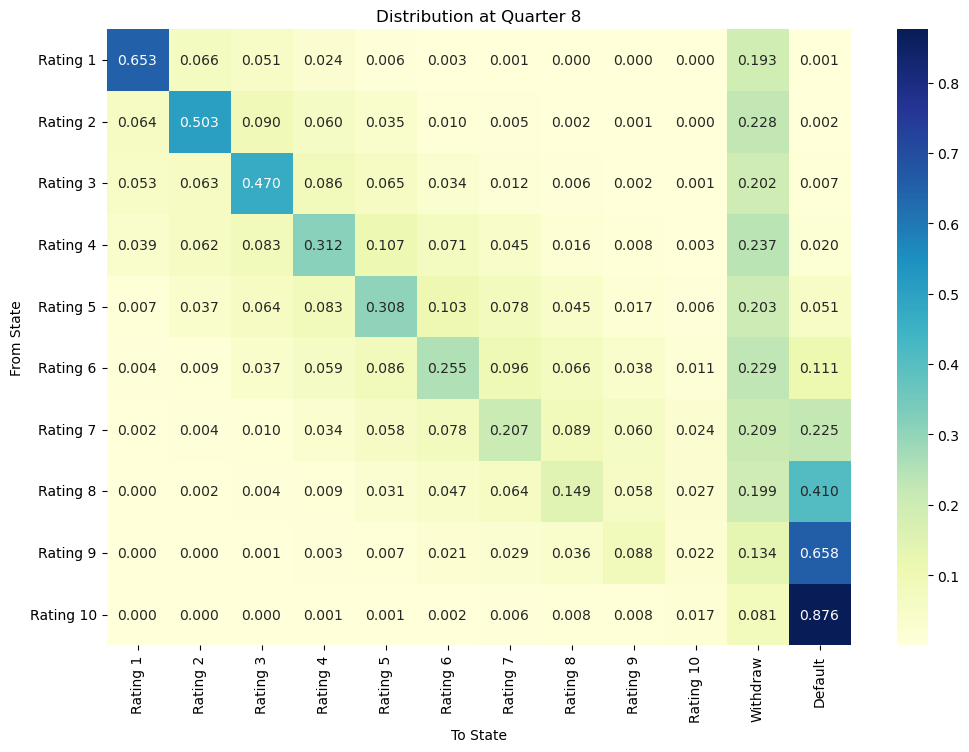

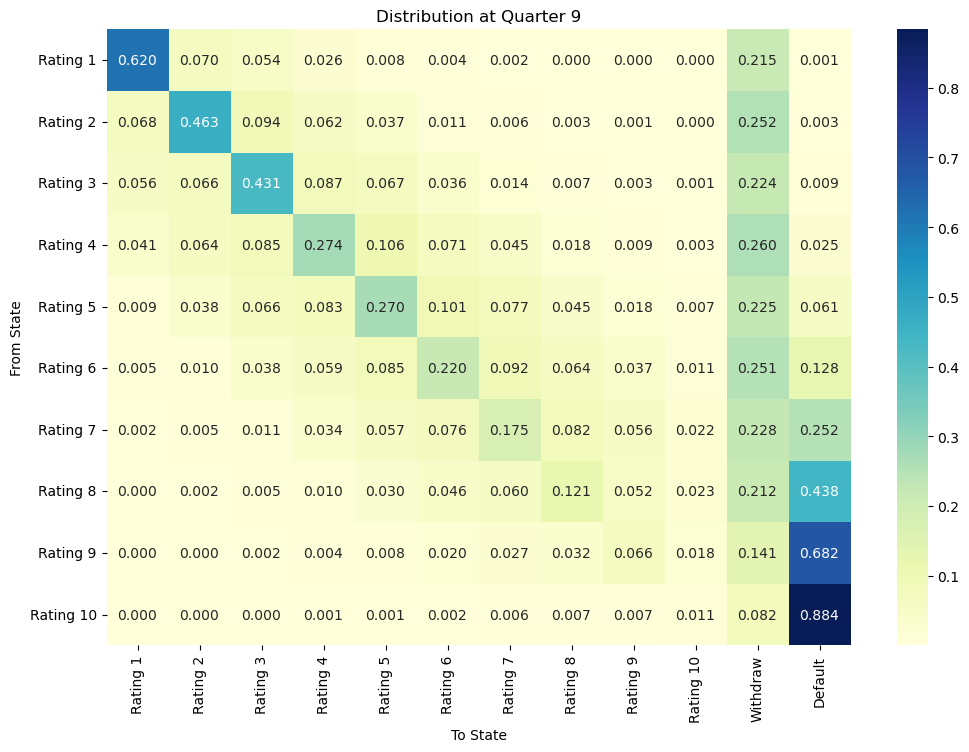

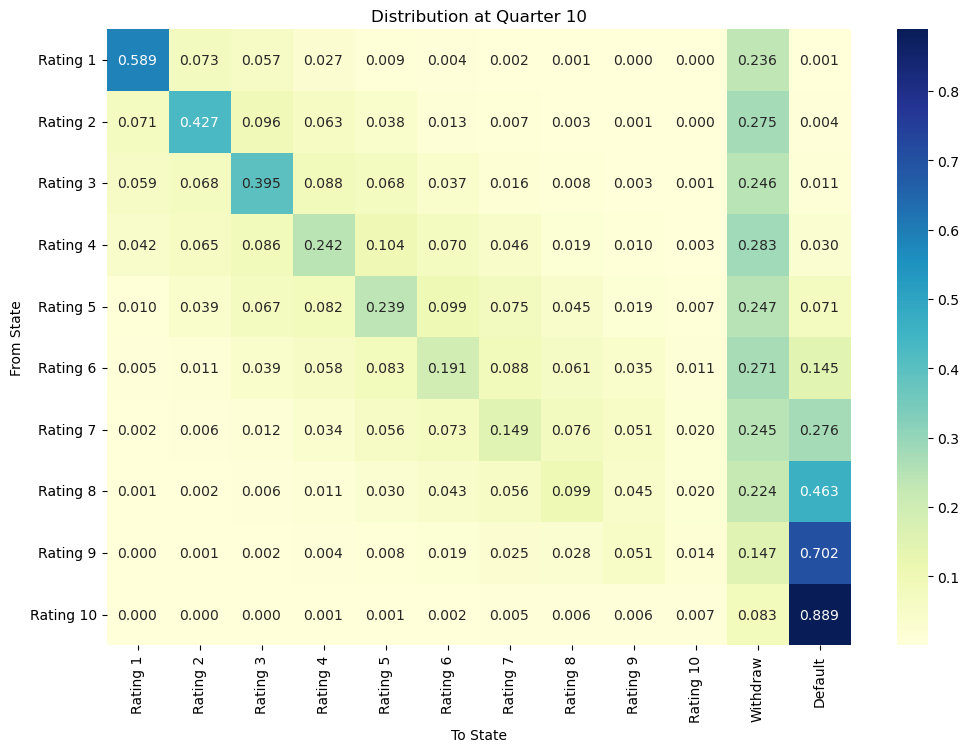

In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def visualize_distributions(distributions_over_time):
    quarters = len(distributions_over_time)
    n_ratings = distributions_over_time[0].shape[0]
    rating_labels = [f'Rating {i+1}' for i in range(n_ratings)] + ['Withdraw', 'Default']

    for t in range(quarters):
        plt.figure(figsize=(12, 8))
        sns.heatmap(distributions_over_time[t], annot=True, fmt=".3f", cmap="YlGnBu", xticklabels=rating_labels, yticklabels=rating_labels[:n_ratings])
        plt.title(f'Distribution at Quarter {t}')
        plt.xlabel('To State')
        plt.ylabel('From State')
        plt.show()

visualize_distributions(distributions_over_time)

In [8]:
import numpy as np

# Parameters
num_obligors = 10000
lgd = 1
ead = 1

def calculate_real_credit_loss_using_default_rates(distributions_over_time, quarter, num_obligors=10000, lgd=1, ead=1):
    # Retrieve the distribution matrix for the specified quarter
    distribution_matrix = distributions_over_time[quarter]
    
    # Extract the default rates (last column of the matrix)
    default_rates = distribution_matrix[:, -1]
    
    # Calculate real loss for each rating
    ecl = num_obligors * default_rates * lgd * ead
    
    return ecl

# Calculate ECL for time 5 and time 10
real_loss_time_5 = calculate_real_credit_loss_using_default_rates(distributions_over_time, 5, num_obligors, lgd, ead)
real_loss_time_10 = calculate_real_credit_loss_using_default_rates(distributions_over_time, 10, num_obligors, lgd, ead)

# Print the ECL values with exact numbers
np.set_printoptions(suppress=True)

print("real loss at time 5 for each rating:")
print(np.around(real_loss_time_5, decimals=2))
print("real loss at time 10 for each rating:")
print(np.around(real_loss_time_10, decimals=2))

real loss at time 5 for each rating:
[   3.38    9.05   30.36   84.76  238.87  598.53 1324.53 2925.57 5372.08
 8162.88]
real loss at time 10 for each rating:
[  11.68   37.64  106.51  297.75  714.3  1448.05 2764.01 4632.2  7015.01
 8889.2 ]


In [9]:
def calculate_default_rates(cumulative_defaults, cumulative_withdraws, cumulative_survivors):
    # Extract first year and second year data
    defaults_first_year = cumulative_defaults[5, :]
    withdraws_first_year = cumulative_withdraws[5, :]
    survivors_first_year = cumulative_survivors[5, :]
    
    defaults_second_year = cumulative_defaults[10, :]
    withdraws_second_year = cumulative_withdraws[10, :]
    survivors_second_year = cumulative_survivors[10, :]
    
    # Compute default rates for the first and second years
    DR_1_orig = defaults_first_year / (defaults_first_year + survivors_first_year)
    DR_1_adjusted_1 = defaults_first_year / (defaults_first_year + survivors_first_year 
                                             + 0.5 * withdraws_first_year)
    DR_1_adjusted_2 = defaults_first_year / (defaults_first_year + survivors_first_year 
                                             + withdraws_first_year)

    DR_2_orig = defaults_second_year / (defaults_second_year + survivors_second_year)
    DR_2_adjusted_1 = defaults_second_year / (defaults_second_year + survivors_second_year + 0.5 * withdraws_second_year)
    DR_2_adjusted_2 = defaults_second_year / (defaults_second_year + survivors_second_year + withdraws_second_year)
    
    return (DR_1_orig, DR_1_adjusted_1, DR_1_adjusted_2), (DR_2_orig, DR_2_adjusted_1, DR_2_adjusted_2)

def format_default_rates(default_rates):
    return [np.round(rate, 6) for rate in default_rates]

In [10]:
# Calculate default rates
default_rates_first_year, default_rates_second_year = calculate_default_rates(cumulative_defaults, 
                                                                              cumulative_withdraws, 
                                                                              cumulative_survivors)

# Format default rates for readability
formatted_default_rates_first_year = [format_default_rates(rate) for rate in default_rates_first_year]
formatted_default_rates_second_year = [format_default_rates(rate) for rate in default_rates_second_year]

# Create DataFrame to display the default rates
df_default_rates_first_year = pd.DataFrame({
    'Rating': [f'{i+1}' for i in range(10)],
    'WTD removed': formatted_default_rates_first_year[0],
    '0.5 * WTD': formatted_default_rates_first_year[1],
    'WTD': formatted_default_rates_first_year[2]
})

df_default_rates_second_year = pd.DataFrame({
    'Rating': [f'{i+1}' for i in range(10)],
    'WTD removed': formatted_default_rates_second_year[0],
    '0.5 * WTD': formatted_default_rates_second_year[1],
    'WTD': formatted_default_rates_second_year[2]
})

# Display the DataFrames
print("\nOriginal CTM(with complete withdraw)")

print("\nDefault Rates for the First 5 unit time:")
print(df_default_rates_first_year)

print("\nDefault Rates for the First 10 unit time:")
print(df_default_rates_second_year)


Original CTM(with complete withdraw)

Default Rates for the First 5 unit time:
  Rating  WTD removed  0.5 * WTD       WTD
0      1     0.000386   0.000360  0.000338
1      2     0.001065   0.000978  0.000905
2      3     0.003490   0.003247  0.003036
3      4     0.010071   0.009205  0.008476
4      5     0.027470   0.025553  0.023887
5      6     0.070900   0.064910  0.059853
6      7     0.154757   0.142739  0.132453
7      8     0.343155   0.315842  0.292557
8      9     0.600695   0.567180  0.537208
9     10     0.880445   0.847153  0.816288

Default Rates for the First 10 unit time:
  Rating  WTD removed  0.5 * WTD       WTD
0      1     0.001529   0.001324  0.001168
1      2     0.005195   0.004365  0.003764
2      3     0.014132   0.012147  0.010651
3      4     0.041538   0.034686  0.029775
4      5     0.094863   0.081495  0.071430
5      6     0.198678   0.167517  0.144805
6      7     0.365855   0.314898  0.276401
7      8     0.596626   0.521527  0.463220
8      9     0.82

In [11]:
import numpy as np
import pandas as pd

def redistribute_half_withdraw_prob(transition_matrix_df):
    transition_matrix = transition_matrix_df.values
    n_ratings = transition_matrix.shape[0]
    
    # Create a new matrix to store the adjusted probabilities
    adjusted_matrix = np.zeros((n_ratings, n_ratings + 1))
    
    for i in range(n_ratings):
        withdraw_prob = transition_matrix[i, -2]
        default_prob = transition_matrix[i, -1]
        remaining_prob = 1 - withdraw_prob - default_prob
        
        existing_probs = transition_matrix[i, :n_ratings]
        sum_existing_probs = np.sum(existing_probs)
        
        # Distribute half of the withdraw prob proportionally among existing probabilities
        proportional_withdraw_existing = (existing_probs / sum_existing_probs) * (0.5 * withdraw_prob)
        
        for j in range(n_ratings):
            adjusted_matrix[i, j] = (existing_probs[j] + proportional_withdraw_existing[j]) / (1 - 0.5 * withdraw_prob)
        
        # Adjust default probability
        adjusted_matrix[i, -1] = default_prob / (1 - 0.5 * withdraw_prob)
    
    # Define row and column labels
    row_labels = [f'Rating {i+1}' for i in range(10)]
    column_labels = [f'Rating {i+1}' for i in range(10)] + ['Default']

    # Create a DataFrame with labels
    adjusted_transition_matrix_df = pd.DataFrame(adjusted_matrix, index=row_labels, columns=column_labels)
    
    return adjusted_transition_matrix_df

# Example usage
adjusted_transition_matrix_df = redistribute_half_withdraw_prob(transition_matrix_df)
adjusted_transition_matrix_df

,Rating 1,Rating 2,Rating 3,Rating 4,Rating 5,Rating 6,Rating 7,Rating 8,Rating 9,Rating 10,Default
Rating 1,0.972463,0.013211,0.009733,0.004542,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000051
Rating 2,0.012315,0.945738,0.020132,0.014766,0.006947,0.000000,0.000000,0.000000,0.000000,0.000000,0.000102
Rating 3,0.010207,0.013024,0.930834,0.023059,0.015583,0.006887,0.000000,0.000000,0.000000,0.000000,0.000405
Rating 4,0.008316,0.015574,0.020824,0.886310,0.035023,0.021300,0.011736,0.000000,0.000000,0.000000,0.000916
Rating 5,0.000000,0.008364,0.015600,0.025019,0.874258,0.035460,0.026156,0.012609,0.000000,0.000000,0.002533
Rating 6,0.000000,0.000000,0.008741,0.018415,0.028225,0.858760,0.039613,0.025789,0.013332,0.000000,0.007124
Rating 7,0.000000,0.000000,0.000000,0.010218,0.018814,0.030362,0.829970,0.048038,0.034228,0.015364,0.013007
Rating 8,0.000000,0.000000,0.000000,0.000000,0.010297,0.019037,0.033202,0.802305,0.044728,0.029174,0.061257
Rating 9,0.000000,0.000000,0.000000,0.000000,0.000000,0.009308,0.016049,0.026122,0.749365,0.039236,0.159921
Rating 10,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004956,0.008852,0.013152,0.613951,0.359089


In [12]:
import numpy as np
import pandas as pd

def simulate_transitions_matrix_without_withdraw(transition_matrix, quarters=11, lgd=1.0, ead=1.0):
    n_ratings = transition_matrix.shape[0]  # Number of ratings (excluding Withdraw and Default)
    n_columns = transition_matrix.shape[1]  # Number of states including Default

    # Initialize matrices to store cumulative results
    cumulative_defaults = np.zeros((quarters, n_ratings))
    cumulative_survivors = np.zeros((quarters, n_ratings))
    distributions_over_time = []  # To store the distribution matrices for each time step
    
    for i in range(n_ratings):
        cumulative_survivors[0, i] = 1

    # Initial distribution of obligors (start with identity matrix for initial distribution)
    current_distribution = np.eye(n_ratings)
    initial_distribution_with_defaults = np.hstack((current_distribution, np.zeros((n_ratings, 1))))
    distributions_over_time.append(initial_distribution_with_defaults.copy())  # Store initial distribution

    for t in range(1, quarters):
        next_distribution = np.zeros_like(current_distribution)

        # Update next_distribution using matrix multiplication
        transitions = np.dot(current_distribution, transition_matrix.values[:, :n_ratings])

        # Update next_distribution matrix
        next_distribution[:, :n_ratings] += transitions
        
        # Accumulate defaults for each rating
        cumulative_defaults[t, :] = cumulative_defaults[t - 1, :] + np.dot(current_distribution, transition_matrix.values[:, -1])
        
        # Update survivors
        cumulative_survivors[t, :] = np.sum(next_distribution[:, :n_ratings], axis=1)

        # Calculate default rates and append to the distribution matrix
        default_rates = cumulative_defaults[t, :].reshape(-1, 1)
        current_distribution_with_defaults = np.hstack((next_distribution, default_rates))
        distributions_over_time.append(current_distribution_with_defaults.copy())  # Store distribution for this quarter

        current_distribution = next_distribution

    return cumulative_defaults, cumulative_survivors, distributions_over_time

cumulative_defaults, cumulative_survivors, distributions_over_time_without_wtd = simulate_transitions_matrix_without_withdraw(adjusted_transition_matrix_df)
cumulative_defaults

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.00005066, 0.00010165, 0.00040547, 0.00091608, 0.00253337,
        0.00712368, 0.01300719, 0.06125744, 0.15992068, 0.35908887],
       [0.00010938, 0.0002377 , 0.00089439, 0.00213157, 0.00614351,
        0.01756029, 0.03800947, 0.12862714, 0.29572396, 0.58226191],
       [0.00017855, 0.00041996, 0.00150803, 0.00386384, 0.0112124 ,
        0.03118978, 0.07047116, 0.19632921, 0.40850476, 0.72178561],
       [0.00026207, 0.00066633, 0.00229512, 0.00626418, 0.01788439,
        0.0476101 , 0.10719639, 0.26115128, 0.50090939, 0.80968981],
       [0.00036511, 0.000998  , 0.00330423, 0.009427  , 0.02615203,
        0.06630909, 0.14595309, 0.32145657, 0.57603868, 0.86562981],
       [0.00049388, 0.0014374 , 0.00457947, 0.01339998, 0.03591491,
        0.08675961, 0.18520348, 0.37656006, 0.63690412, 0.90168823],
       [0.00065536, 0.0020067 , 0.0061581

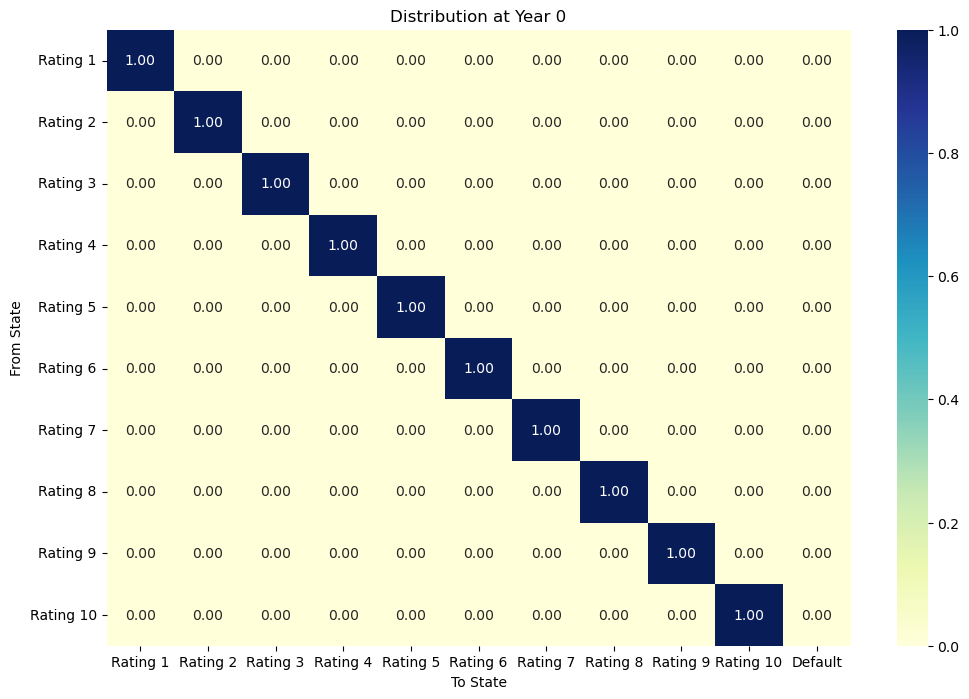

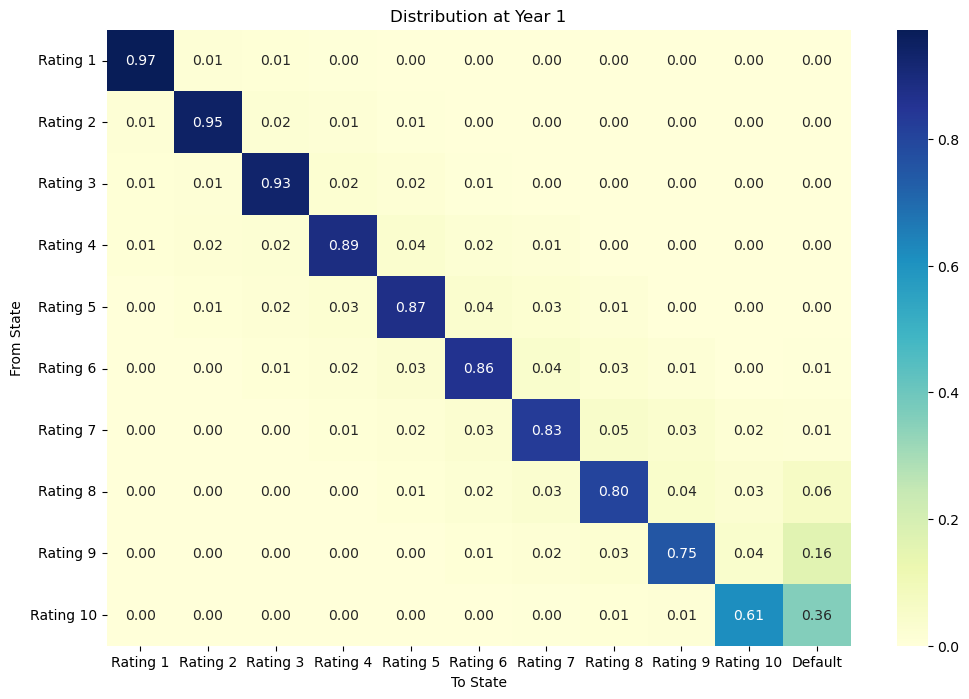

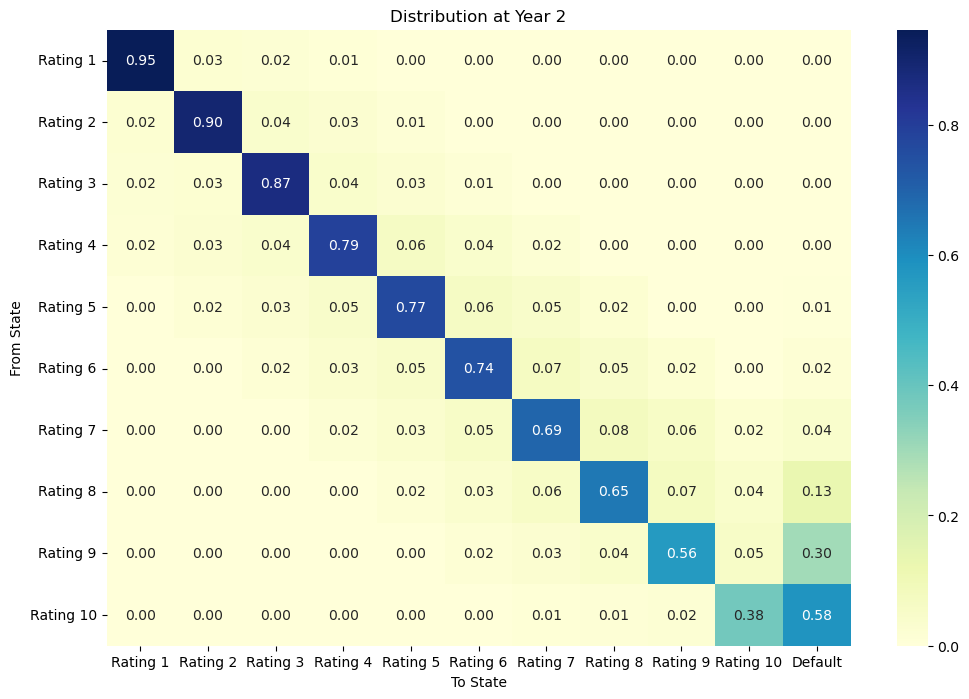

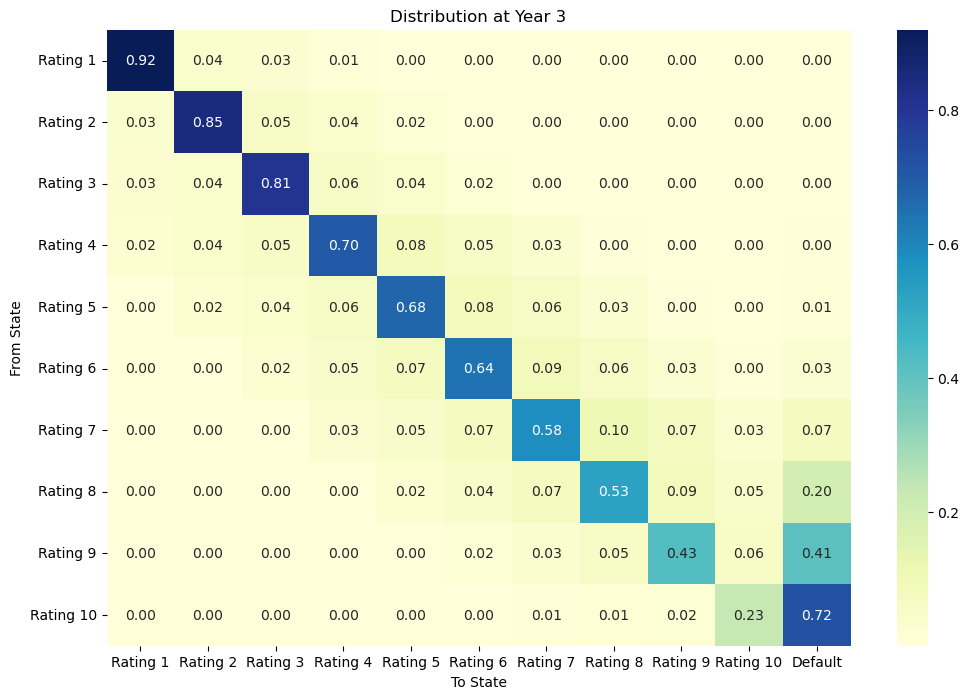

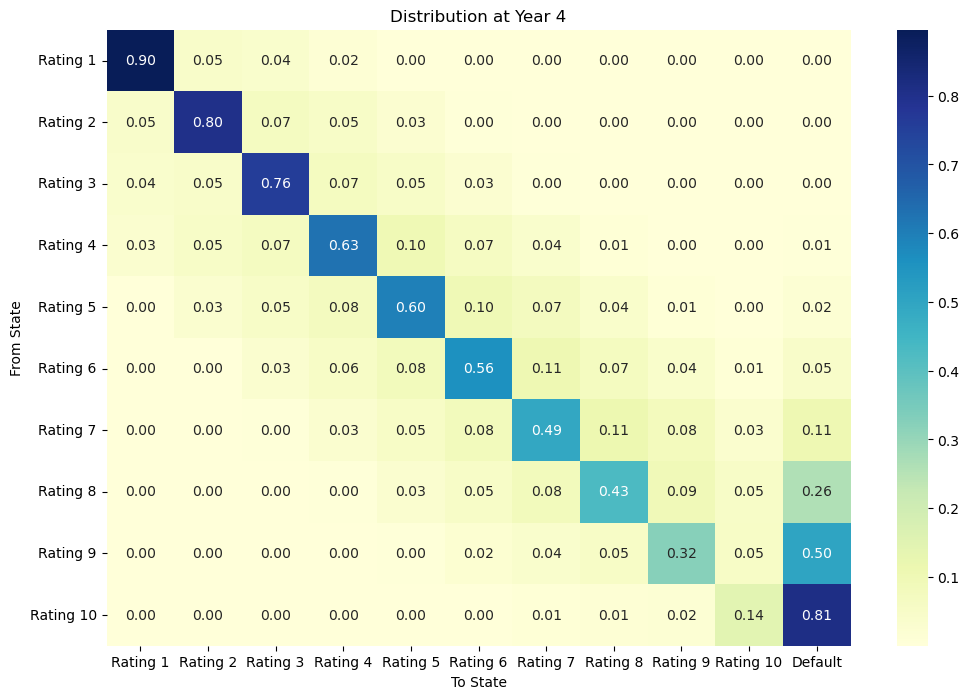

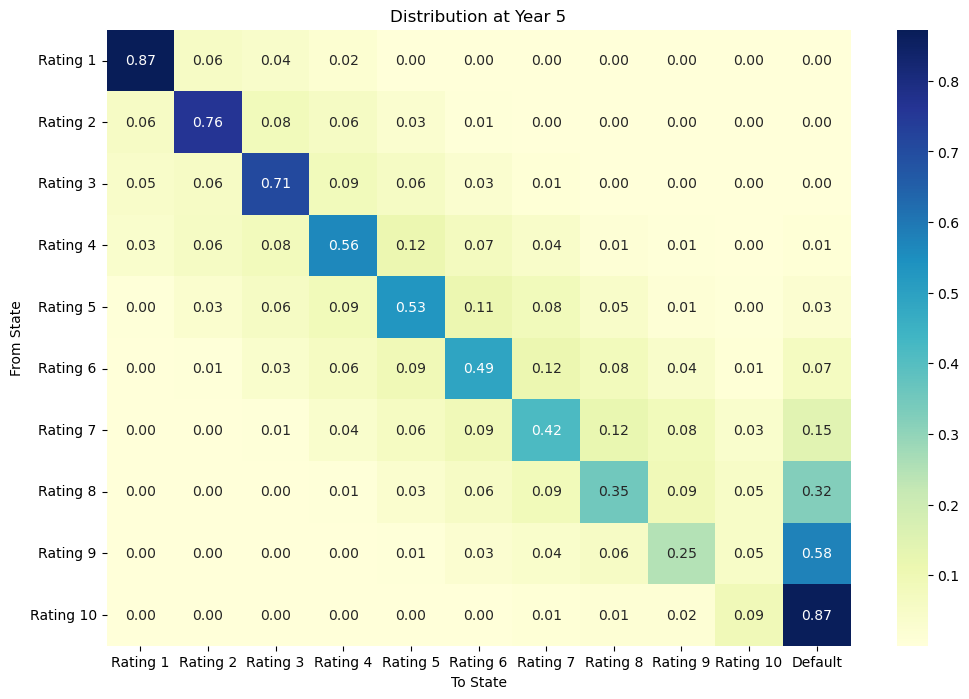

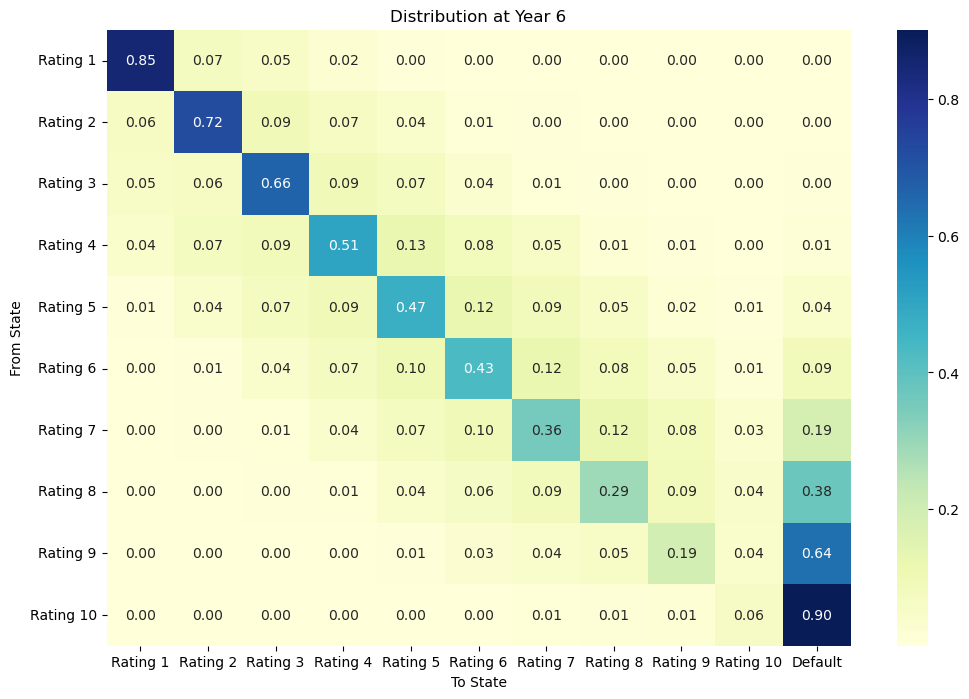

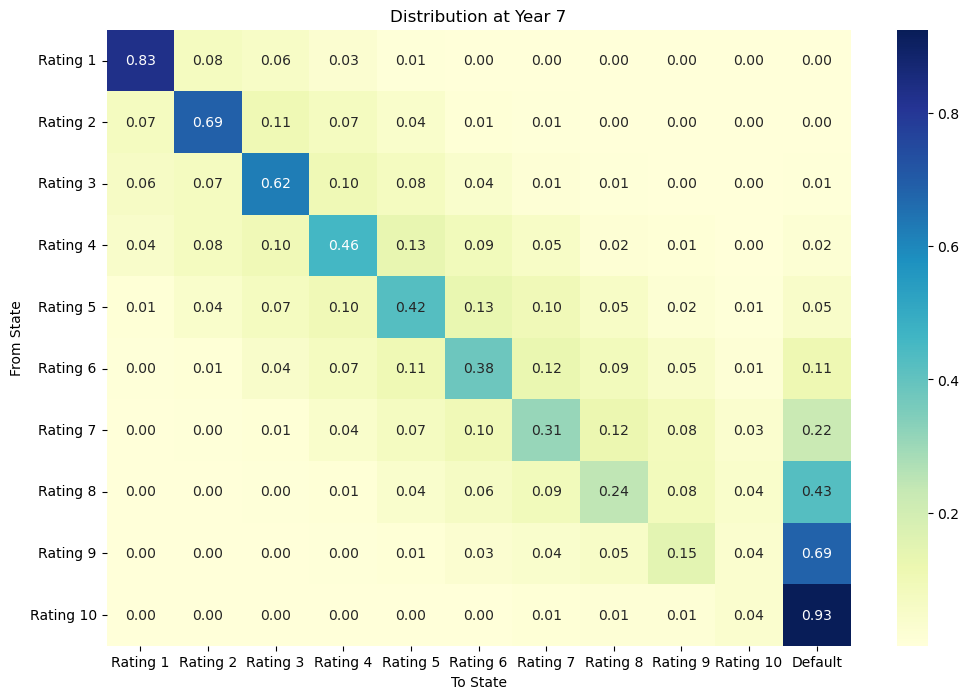

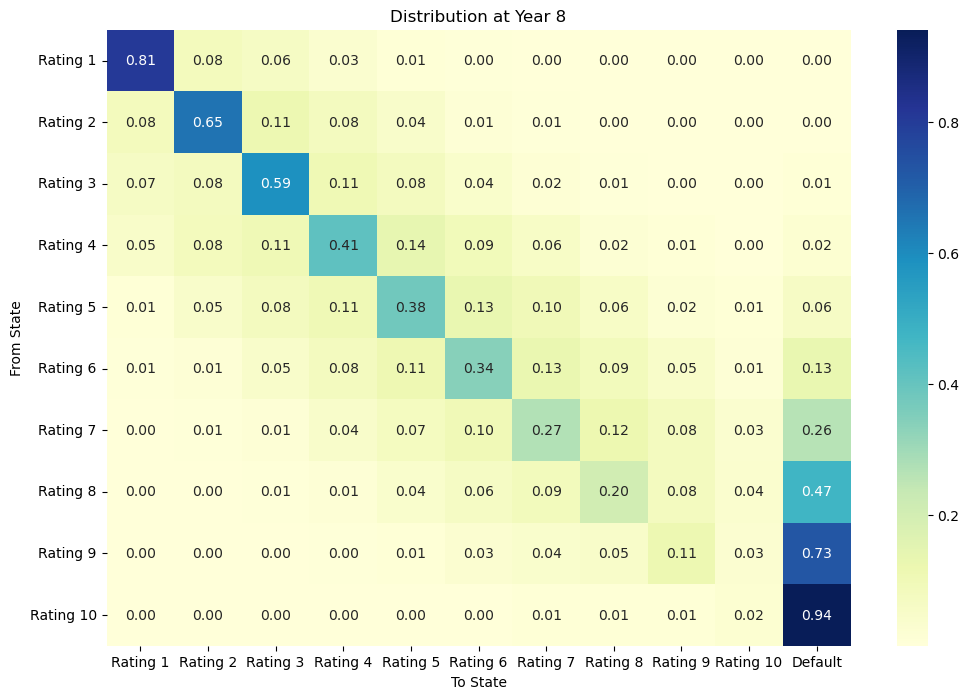

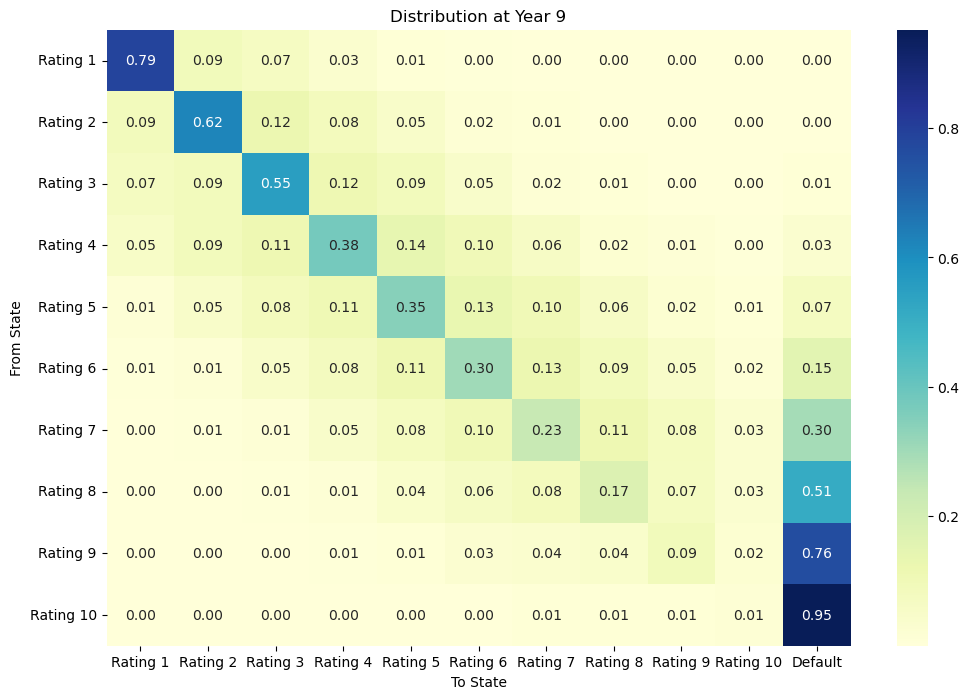

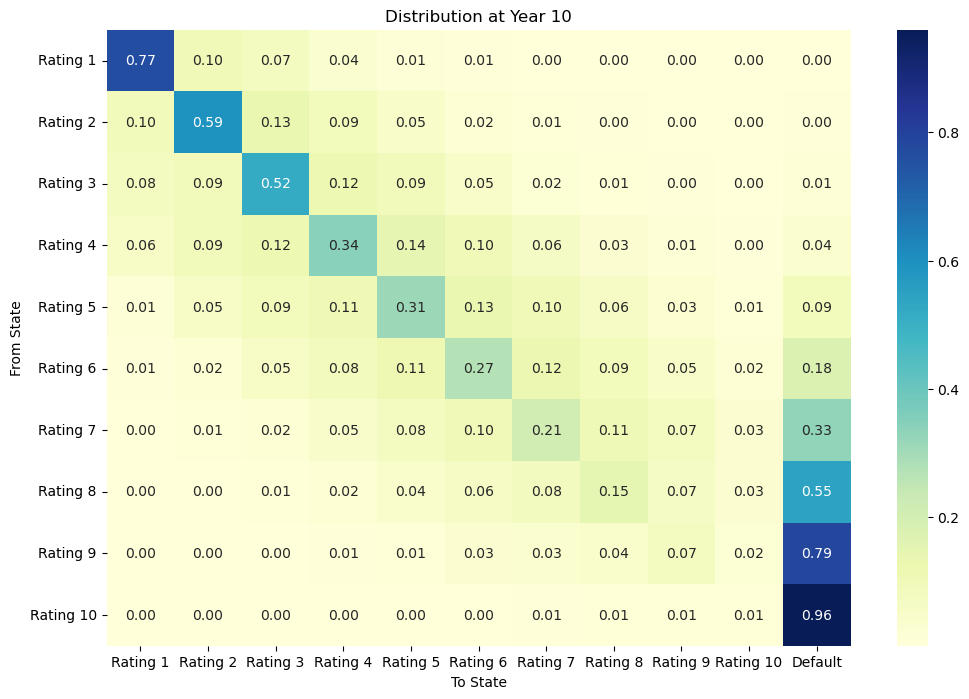

In [14]:
def visualize_distributions(distributions_over_time, title_prefix="Distribution"):
    quarters = len(distributions_over_time)
    n_ratings = distributions_over_time[0].shape[0]
    rating_labels = [f'Rating {i+1}' for i in range(n_ratings)] + ['Default']

    for t in range(quarters):
        plt.figure(figsize=(12, 8))
        sns.heatmap(distributions_over_time[t], annot=True, fmt=".2f", cmap="YlGnBu", xticklabels=rating_labels, yticklabels=rating_labels[:n_ratings])
        plt.title(f'{title_prefix} at Year {t}')
        plt.xlabel('To State')
        plt.ylabel('From State')
        plt.show()

visualize_distributions(distributions_over_time_without_wtd)

In [15]:
# Parameters
num_obligors = 10000
lgd = 1
ead = 1

def calculate_ecl(distributions_over_time, cumulative_withdraws, quarter, num_obligors=10000, lgd=1, ead=1):
    # Retrieve the distribution matrix for the specified quarter
    distribution_matrix = distributions_over_time[quarter]
    
    # Extract the default rates (last column of the matrix)
    default_rates = distribution_matrix[:, -1]
    
    # Extract the cumulative withdraw rates for the specified quarter
    withdraw_rates = cumulative_withdraws[quarter, :]
    
    # Adjust the number of obligors by deducting the withdraws
    adjusted_obligors = num_obligors * (1 - withdraw_rates)
    
    # Calculate ECL for each rating
    ecl = adjusted_obligors * default_rates * lgd * ead
    
    return ecl

# Calculate ECL for time 5 and time 10
ecl_time_5 = calculate_ecl(distributions_over_time_without_wtd, cumulative_withdraws, 5, num_obligors, lgd, ead)
ecl_time_10 = calculate_ecl(distributions_over_time_without_wtd, cumulative_withdraws, 10, num_obligors, lgd, ead)

# Print the ECL values with exact numbers
np.set_printoptions(suppress=True)

print("ECL at time 5 for each rating:")
print(np.around(ecl_time_5, decimals=2))
print("ECL at time 10 for each rating:")
print(np.around(ecl_time_10, decimals=2))

ECL at time 5 for each rating:
[   3.2     8.48   28.75   79.33  227.4   559.77 1249.18 2740.58 5151.57
 8025.52]
ECL at time 10 for each rating:
[  10.79   34.01   97.76  266.88  651.83 1290.92 2502.06 4241.97 6702.21
 8797.66]


In [ ]:
real loss at time 5 for each rating:
[   345.17    851.02   3111.31   7993.8   24284.94  64307.84 132269.64
 301512.14 537277.95 816611.02]
real loss at time 10 for each rating:
[  1215.68   3429.92  11127.58  28176.95  73152.06 159590.6  279749.58
 483823.49 706798.66 888873.39]

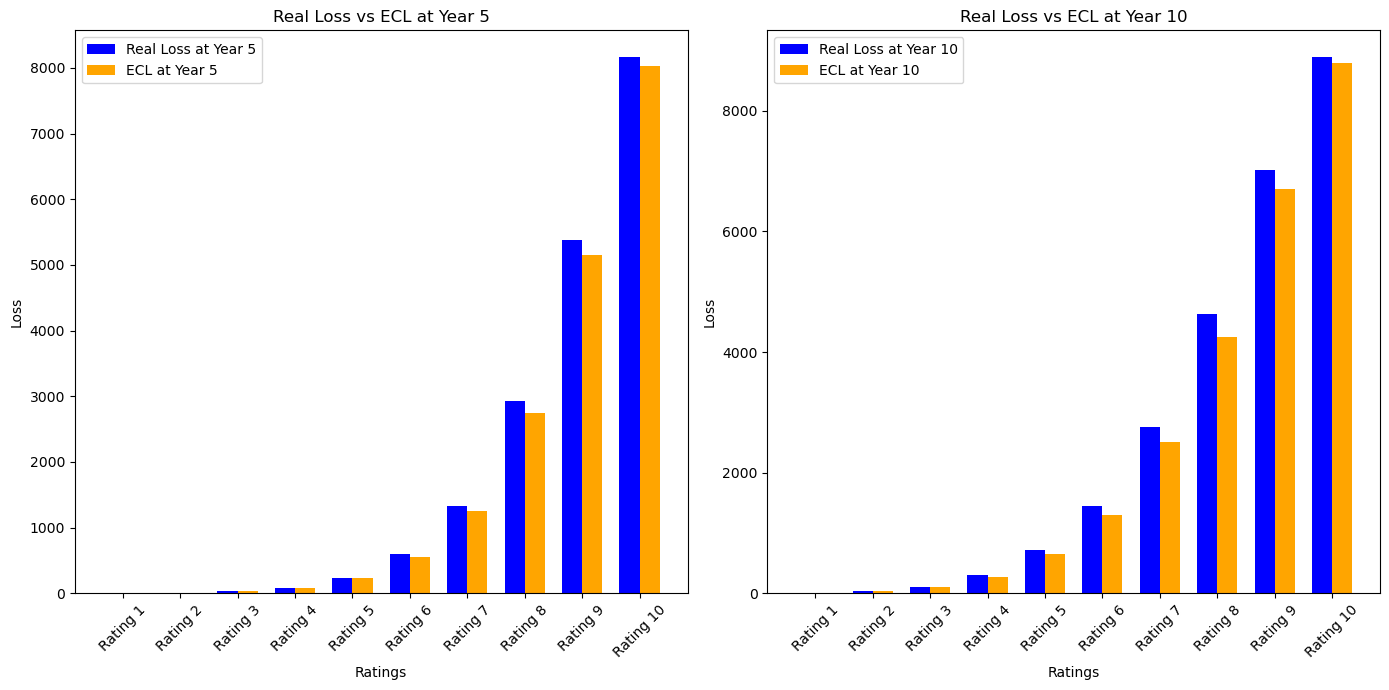

In [18]:
ratings = [f'Rating {i+1}' for i in range(10)]

# Plotting for Time 5
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
bar_width = 0.35
index = np.arange(len(ratings))

bar1 = plt.bar(index, real_loss_time_5, bar_width, label='Real Loss at Year 5', color='blue')
bar2 = plt.bar(index + bar_width, ecl_time_5, bar_width, label='ECL at Year 5', color='orange')

plt.xlabel('Ratings')
plt.ylabel('Loss')
plt.title('Real Loss vs ECL at Year 5')
plt.xticks(index + bar_width / 2, ratings, rotation=45)
plt.legend()

# Plotting for Time 10
plt.subplot(1, 2, 2)

bar1 = plt.bar(index, real_loss_time_10, bar_width, label='Real Loss at Year 10', color='blue')
bar2 = plt.bar(index + bar_width, ecl_time_10, bar_width, label='ECL at Year 10', color='orange')

plt.xlabel('Ratings')
plt.ylabel('Loss')
plt.title('Real Loss vs ECL at Year 10')
plt.xticks(index + bar_width / 2, ratings, rotation=45)
plt.legend()

plt.tight_layout()
plt.show()